# Advanced Lane Finding Project

## 1. Camera Calibration & Distortion Correction

The code for calibrating the camera und undistort images in show in the cell below.

In [1]:
# %load calibration.py
import numpy as np
import cv2
import glob
import pickle

class Calibration:

    def do_calibration(self, calibration_path, nx, ny):
        objp = np.zeros((ny * nx, 3), np.float32)
        objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

        # Arrays to store object points and image points from all the images.
        objpoints = []  # 3d points in real world space
        imgpoints = []  # 2d points in image plane.

        # Make a list of calibration images
        images = glob.glob(calibration_path + '/*.jpg')

        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

        img = cv2.imread(images[0])
        img_size = (img.shape[1], img.shape[0])
        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

        self.calibration_data = (mtx, dist)

        return ret

    def calibrate(self, calibration_path, nx=9, ny=6):
        cal_datat_file = calibration_path + "/calibration_data.p"
        try:
            with open(cal_datat_file, "rb") as f:
                self.calibration_data = pickle.load(f)
        except Exception as error:
            if self.do_calibration(calibration_path, nx, ny):
                pickle.dump(self.calibration_data, open(cal_datat_file, "wb"))

    def undistort(self, img):
        mtx = self.calibration_data[0]
        dist = self.calibration_data[1]
        return cv2.undistort(img, mtx, dist, None, mtx)

### Example


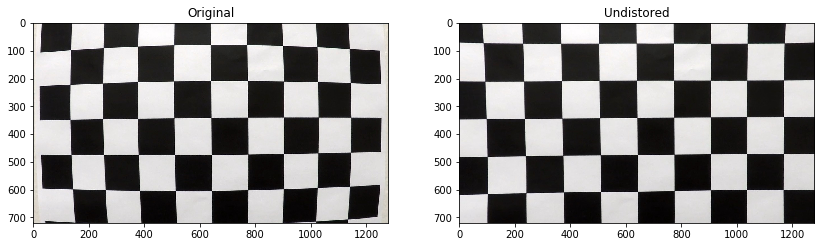

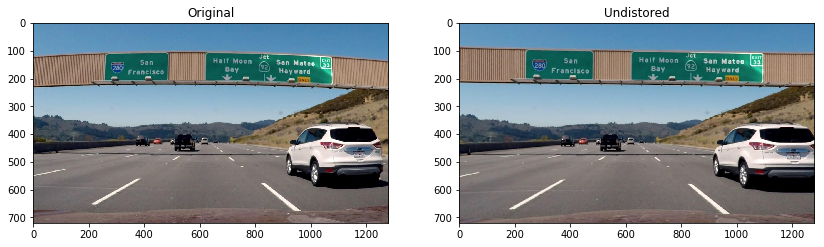

In [7]:
from calibration import Calibration
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Calibrate camera using all images in camera_cal folder:
cal = Calibration()
cal.calibrate('camera_cal')

test_images = ['camera_cal/calibration1.jpg', 'test_images/test0.jpg']
for test_image in test_images:
    img = mpimg.imread(test_image)
    undist = cal.undistort(img)

    f, (axis1, axis2) = plt.subplots(1, 2, figsize=(14,10)) 
    axis1.imshow(img)
    axis1.set_title('Original')
    axis2.imshow(undist)
    axis2.set_title('Undistored')


## 2. Perspective Transform

The code for transforming images to bird eyes view and back is show in the cell below.

I used the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 490, 482      | 0, 0        | 
| 810, 482      | 1280, 0      |
| 1250, 720     | 1280, 720      |
| 40, 720       | 0 720        |


In [3]:
# %load perspective.py
import numpy as np
import cv2

class Transformer:
    def __init__(self):
        src = np.float32(
            [[490, 482],
             [810, 482],
             [1250, 720],
             [40, 720]])

        dst = np.float32(
            [[0, 0],
             [1280, 0],
             [1280, 720],
             [0, 720]])

        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)


    def to_top_view(self, img):
        img_size = (img.shape[1], img.shape[0])
        warped = cv2.warpPerspective(img, self.M, img_size, flags=cv2.INTER_LINEAR)
        return warped

    def from_top_view(self, img):
        img_size = (img.shape[1], img.shape[0])
        warped = cv2.warpPerspective(img, self.Minv, img_size, flags=cv2.INTER_LINEAR)
        return warped

### Example

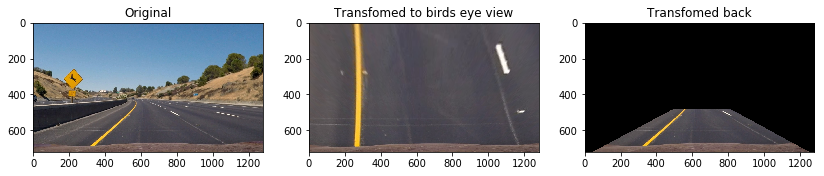

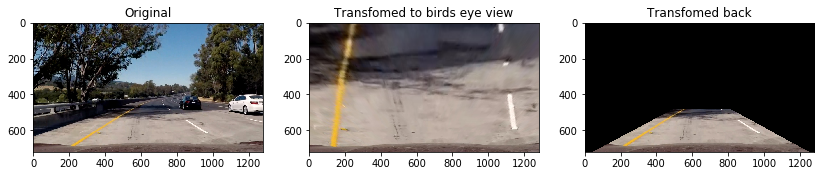

In [4]:
transform = Transformer()

for test_image in ['test_images/test2.jpg', 'test_images/test5.jpg']:
    img = mpimg.imread(test_image)
    
    trans = transform.to_top_view(img)
    trans_back = transform.from_top_view(trans)
    
    f, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(14,10)) 
    axis1.set_title('Original')
    axis1.imshow(img)
    axis2.set_title('Transfomed to birds eye view')
    axis2.imshow(trans)
    axis3.set_title('Transfomed back')
    axis3.imshow(trans_back)

## 3. Image Thresholding

The code for thresholding the images in show in the cell below.

In [5]:
# %load threshold.py
import cv2
import numpy as np

def sobel(img, sobel_kernel, x=1, y=1):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    if x & y:
        return sobelx, sobely
    elif x:
        return sobelx
    else:
        return sobelx

def make_binary(img, thresh):
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_img = np.zeros_like(img)
    thresh_cond = (img >= thresh[0]) & (img <= thresh[1])
    binary_img[thresh_cond] = 1
    return binary_img

def scale_to_8bit(img):
    scale_factor = np.max(img) / 255
    return (img / scale_factor).astype(np.uint8)


def abs_sobel_threshold(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        abs_sobel = sobel(img, sobel_kernel, 1, 0)
    if orient == 'y':
        abs_sobel = sobel(img, sobel_kernel, 0, 1)

    scaled_sobel = scale_to_8bit(abs_sobel)

    return make_binary(scaled_sobel, thresh)

def magnitude_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # Apply sobel filter in x and y direction
    sobelx, sobely = sobel(img, sobel_kernel)

    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    gradmag = scale_to_8bit(gradmag)

    return make_binary(gradmag, thresh)

def direction_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Apply sobel filter in x and y direction
    sobelx, sobely = sobel(img, sobel_kernel)

    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    return make_binary(absgraddir, thresh)

def s_channel_threshold(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    return make_binary(s_channel, thresh)

def l_channel_threshold(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    l_channel = hls[:,:,0]
    return make_binary(l_channel, thresh)

def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)

    return mask

def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)

    return mask

After playing arround with all the different thresholding methods I found that a combination of 
**s_channel_threshold** and **l_channel_threshold** produces best results.

The result of combining these two thresholding methods is shown by the example below.

### Example

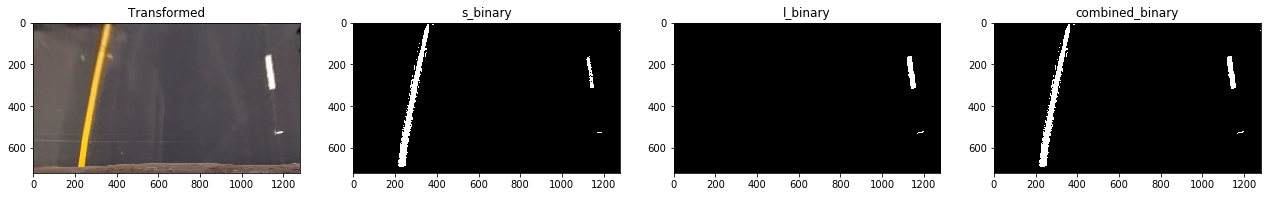

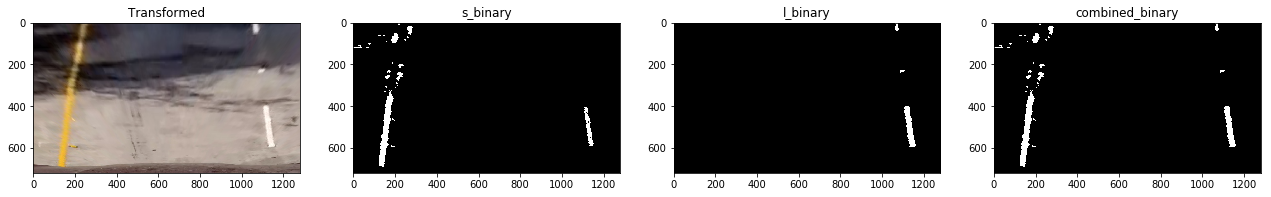

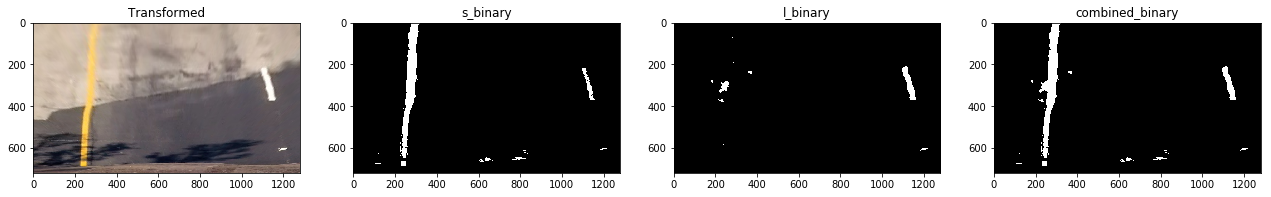

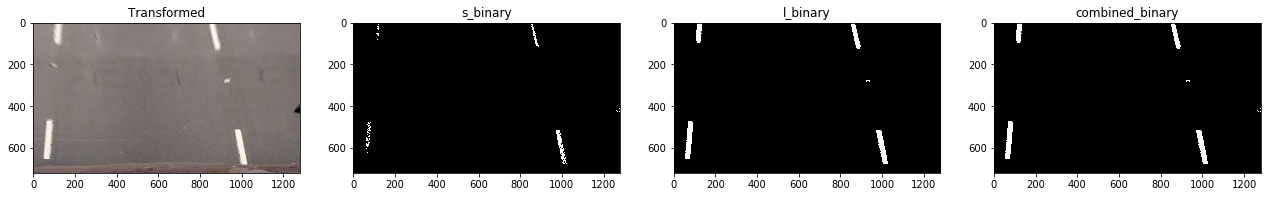

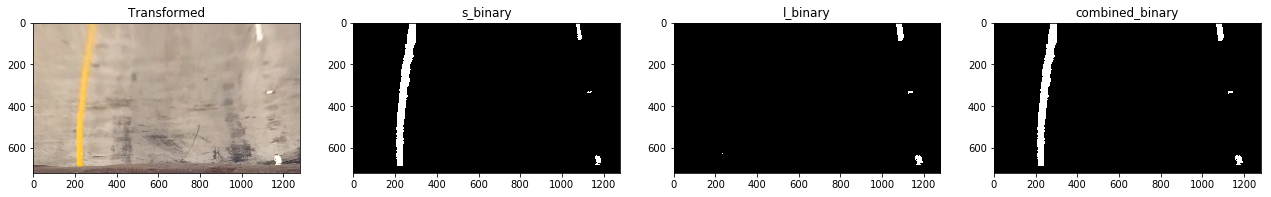

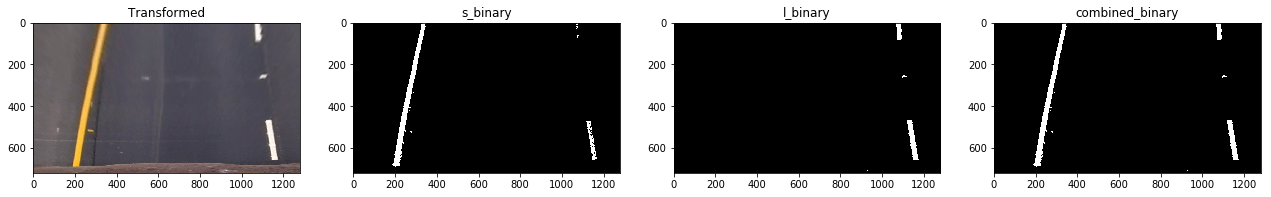

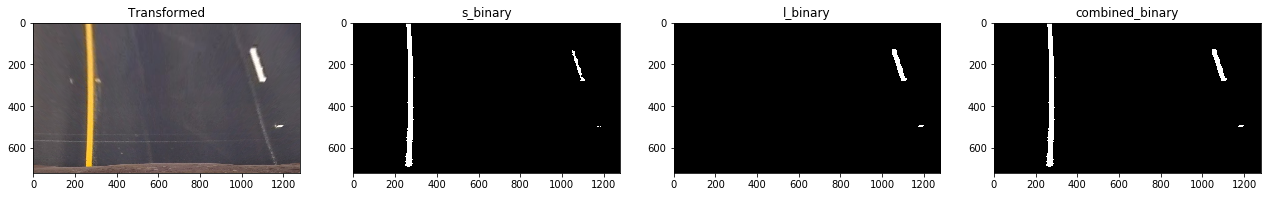

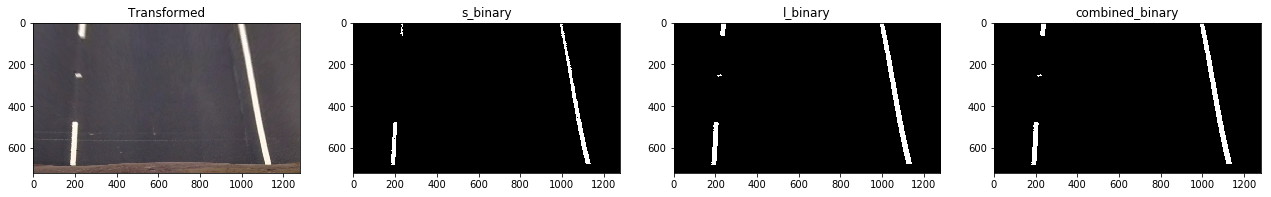

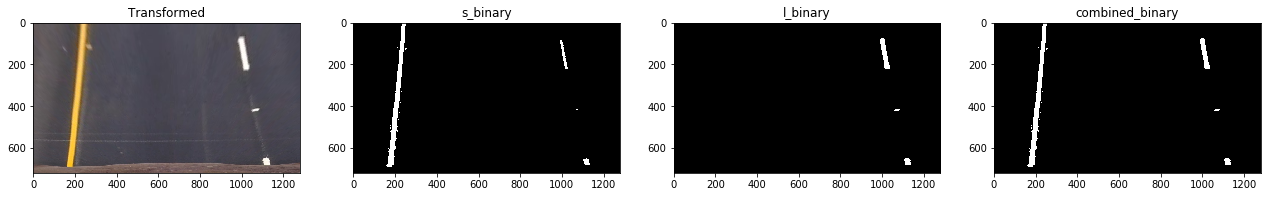

In [6]:
test_images = 'test_images/*.jpg'  
for test_image in glob.glob(test_images):
    image = mpimg.imread(test_image)
    image = transform.to_top_view(image)

    s_binary = s_channel_threshold(image, thresh=(150, 255))
    l_binary = l_channel_threshold(image, thresh=(210, 255))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (l_binary == 1)] = 1

    #Plotting
    f, (axis1, axis2, axis3, axis4) = plt.subplots(1, 4, figsize=(22,22)) 
    axis1.set_title('Transformed')
    axis1.imshow(image, cmap='gray')
    axis2.set_title('s_binary')
    axis2.imshow(s_binary, cmap='gray')
    axis3.set_title('l_binary')
    axis3.imshow(l_binary, cmap='gray')
    axis4.set_title('combined_binary')
    axis4.imshow(combined_binary, cmap='gray')

## 4. Line Finding and Poyline Fitting

The cell below contains the code for finding the lane lines in the image and the polyline line fitting.


The fitting is can be done in two ways. If no valid fitting exists (line 146-147) left and right lines are detected by using the **sliding window** approach introduced in this module.

If fitting was already successful before (line 144-145) left and right lines are searched in the near area of the existing fit.


In [9]:
# %load find_lanes.py
import numpy as np

def sliding_window_search(nonzero_pixels, img_height, start_pos_x):

    # Identify the x and y positions of all nonzero pixels in the image
    nonzeroy = np.array(nonzero_pixels[0])
    nonzerox = np.array(nonzero_pixels[1])

    # Choose number and height of sliding windows
    nwindows = 9
    window_height = np.int(img_height / nwindows)

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive line pixel indices
    lane_inds = []

    # Current positions to be updated for each window
    x_current = start_pos_x
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_height - (window + 1) * window_height
        win_y_high = img_height - window * window_height

        win_x_low = x_current - margin
        win_x_high = x_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]

        # Append these indices to the lists
        lane_inds.append(good_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_inds) > minpix:
            x_current = np.int(np.mean(nonzerox[good_inds]))

    # Concatenate the arrays of indices
    lane_inds = np.concatenate(lane_inds)

    # Extract ine pixel positions
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds]
    return [x, y]

def fit_polynom(pixels: object, deg: object = 2) -> object:

    assert(len(pixels[0]) > 0)
    assert (len(pixels[1]) > 0)
    return np.polyfit(pixels[1], pixels[0], deg)

class MovingAverage:
    def __init__(self, n_window):
        self.n_window = n_window
        self.list = []

    def add(self, x):

        if(len(self.list) >= self.n_window):
            self.list.pop(0)

        self.list.append(x)

        return np.average(np.array(self.list), axis=0)

class LineFitter:

    def __init__(self):

        self.left_poly_param = None
        self.right_poly_param = None

        self.left_poly_param_av = MovingAverage(12)
        self.right_poly_param_av = MovingAverage(12)

        self.left_line_pixels = None
        self.right_line_pixels = None

        self.valid_fitting_exits = False

    def initial_fit(self, binary_img):
        img_height = binary_img.shape[0]

        # histogram of the bottom half of the image
        histogram = np.sum(binary_img[0:int(img_height / 2), :], axis=0)

        # Find left and right peaks in the histogram
        # These will be the starting points for the left and right lines
        midpoint = np.int(histogram.shape[0] / 2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        nonzero = binary_img.nonzero()

        # Search for left and right pixels
        left_pixels = sliding_window_search(nonzero, img_height, leftx_base)
        right_pixels = sliding_window_search(nonzero, img_height, rightx_base)

        assert (len(left_pixels[0]) == len(left_pixels[1]))
        assert (len(right_pixels[0]) == len(right_pixels[1]))


        if len(left_pixels[0]) > 0 and len(right_pixels[0]) > 0:
            self.valid_fitting_exits = True
            self.left_line_pixels = left_pixels
            self.right_line_pixels = right_pixels

            assert (len(self.left_line_pixels[0]) > 0)
            assert (len(self.left_line_pixels[1]) > 0)

            assert (len(self.right_line_pixels[0]) > 0)
            assert (len(self.right_line_pixels[1]) > 0)
        else:
            self.__init__()

    def find_pixels_arround_line(self, binary_img, poly_param):
        nonzero = binary_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        margin = 100
        line_fit = poly_param
        line_inds = ((nonzerox > (line_fit[0] * (nonzeroy ** 2) + line_fit[1] * nonzeroy +
                                  line_fit[2] - margin)) & (nonzerox < (line_fit[0] * (nonzeroy ** 2) +
                                                                        line_fit[1] * nonzeroy + line_fit[
                                                                                 2] + margin)))
        line_pixels = [nonzerox[line_inds], nonzeroy[line_inds]]

        return line_pixels

    def easy_fit(self, binary_img):
        nonzero = binary_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        margin = 100
        left_fit = self.left_poly_param
        right_fit = self.right_poly_param

        assert(left_fit is not None)
        assert(right_fit is not None)

        left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy +
                                       left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) +
                                                                             left_fit[1] * nonzeroy + left_fit[
                                                                                 2] + margin)))

        right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy +
                                        right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                                                               right_fit[1] * nonzeroy + right_fit[
                                                                                   2] + margin)))

        left_pixels = [nonzerox[left_lane_inds], nonzeroy[left_lane_inds]]
        right_pixels = [nonzerox[right_lane_inds], nonzeroy[right_lane_inds]]

        assert (len(left_pixels[0]) == len(left_pixels[1]))
        assert (len(right_pixels[0]) == len(right_pixels[1]))

        if len(left_pixels[0]) > 0 and len(right_pixels[0]) > 0:
            self.valid_fitting_exits = True
            self.left_line_pixels = left_pixels
            self.right_line_pixels = right_pixels

            assert (len(self.left_line_pixels[0]) > 0)
            assert (len(self.left_line_pixels[1]) > 0)

            assert (len(self.right_line_pixels[0]) > 0)
            assert (len(self.right_line_pixels[1]) > 0)
        else:
            self.__init__()

    def fit_lines(self, binary_img):

        if self.valid_fitting_exits:
            self.easy_fit(binary_img)
        else:
            self.initial_fit(binary_img)

        if self.valid_fitting_exits:
            # Fit a second order polynomial to each

            assert (self.left_line_pixels is not None), "Left list is empty."
            assert (self.right_line_pixels is not None), "Right list is empty."

            self.left_poly_param = self.left_poly_param_av.add(fit_polynom(self.left_line_pixels))
            self.right_poly_param = self.right_poly_param_av.add(fit_polynom(self.right_line_pixels))

            # self.left_poly_param = fit_polynom(self.left_line_pixels)
            # self.right_poly_param = fit_polynom(self.right_line_pixels)

        return self.valid_fitting_exits

    def get_poly_params(self):
        return self.left_poly_param, self.right_poly_param


## 5. Image Processing Pipeline

The code of the final lane finding pipeline is shown below.
The pipeline contains the following major steps:

* Undistort image (line 29)
* Transform image to bird eyes view (line 32)
* Applying the combined binary threshold (line 35 - 39)
* Search lane lines and fit a polynomial to each line (line 41)
* Calculate the vehicle offset to the lane center(line 60-65)
* Calculate the lane curvature radius (line 68-73)
* Annotate the image with the polynomials (line 76-82)
* Transform image back from bird eyes view to the original perspective (line 84)
* Plot the calcualted vehicle offset and lane curvature radius on the result image (line 89-94)

Note: In contrast to the processing pipeline introduced by this module I swaped the thresholding and trasformation step, because I found it easier to experiment with the thresholds on the wraped image.

In [12]:
# %load pipeline.py
import matplotlib.pyplot as plt
from threshold import s_channel_threshold, l_channel_threshold
import numpy as np
import cv2

def curve_radius(poly_param, x):
    A = poly_param[0]
    B = poly_param[1]
    numerator = (1 + (2 * A * x + B) ** 2) ** 1.5
    denominator = np.absolute(2 * A)
    return numerator / denominator


def evaluate_2d_polynom_at(poly_param, x):
    A = poly_param[0]
    B = poly_param[1]
    C = poly_param[2]
    return A * x ** 2 + B * x + C

class Pipeline:

    def __init__(self, calibration, transform, line_fitter):
        self.transform = transform
        self.calibration = calibration
        self.line_fitter = line_fitter

    def process_image(self, orig_img, debug=False):
        orig_img = self.calibration.undistort(orig_img)
        img_size = {'x': orig_img.shape[1], 'y': orig_img.shape[0]}

        wraped_img = self.transform.to_top_view(orig_img)

        # Apply each of the thresholding functions
        s_binary = s_channel_threshold(wraped_img, thresh=(150, 255))
        l_binary = l_channel_threshold(wraped_img, thresh=(210, 255))


        combined_binary = np.zeros_like(s_binary)
        combined_binary[(s_binary == 1) | (l_binary == 1)] = 1

        success = self.line_fitter.fit_lines(combined_binary)

        if not success:
            return orig_img

        left_fit, right_fit = self.line_fitter.get_poly_params()

        # Generate x and y pixel values
        ploty = np.linspace(0, img_size['y']-1, img_size['y'])
        leftx = evaluate_2d_polynom_at(left_fit, ploty)
        rightx = evaluate_2d_polynom_at(right_fit, ploty)


        # Caculate x positions of lane lines a the image botton
        left_x_bottom = evaluate_2d_polynom_at(left_fit, img_size['y'])
        right_x_bottom = evaluate_2d_polynom_at(right_fit, img_size['y'])
        x_bottom_distance = right_x_bottom - left_x_bottom

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30 / img_size['y']  # meters per pixel in y dimension
        xm_per_pix = 3.7 / x_bottom_distance  # meters per pixel in x dimension

        # Calculate vehicle center offset
        img_center_x = img_size['x'] / 2
        vehicles_center_offset_pixel = img_center_x - ((right_x_bottom + left_x_bottom) / 2)
        vehicles_center_offset_meter = vehicles_center_offset_pixel * xm_per_pix

        # Calculate radius
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)

        # Calculate the new radii of curvature
        y_eval = np.max(ploty) * ym_per_pix
        left_curverad = curve_radius(left_fit_cr, y_eval)
        right_curverad = curve_radius(right_fit_cr, y_eval)
        curverad = (left_curverad + right_curverad) / 2

        # Draw lines on the image
        warped_zero = np.zeros_like(combined_binary).astype(np.uint8)
        color_warped = np.dstack((warped_zero, warped_zero, warped_zero))
        pts_left = np.array([np.flipud(np.transpose(np.vstack([leftx, ploty])))])
        pts_right = np.array([np.transpose(np.vstack([rightx, ploty]))])
        pts = np.hstack((pts_left, pts_right))
        cv2.polylines(color_warped, np.int_([pts]), isClosed=False, color=(255, 0, 0), thickness = 40)
        cv2.fillPoly(color_warped, np.int_([pts]), (0, 255, 0))

        new_warp = self.transform.from_top_view(color_warped)

        result = cv2.addWeighted(orig_img, 1, new_warp, 0.9, 0)

        # Print vehicle offset
        cv2.putText(result, 'Vehicle center offset : {:+.2f}m'.format(vehicles_center_offset_meter), (100, 80),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.8, color=(255, 255, 255), thickness=2)

        # Print radius of curvature on video
        cv2.putText(result, 'Lane curvature radius : {:.2f}m'.format(curverad), (120, 140),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1.8, color=(255, 255, 255), thickness=2)


        if debug:
            f, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(25, 25))
            axis1.set_title('Original')
            axis1.imshow(orig_img)

            axis2.set_title('Line detection')
            axis2.imshow(wraped_img, cmap='gray')
            axis2.plot(leftx, ploty, color='red', linewidth=3)
            axis2.plot(rightx, ploty, color='red', linewidth=3)

            axis3.set_title('Result')
            axis3.imshow(result)

        return result


### Example: Processing Pipeline (single image)

The following cell shows the results of the full image processing pipeline on two test images.

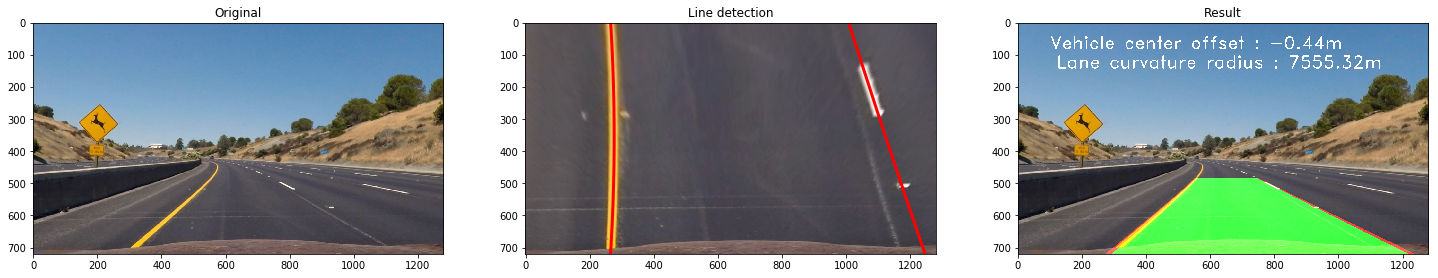

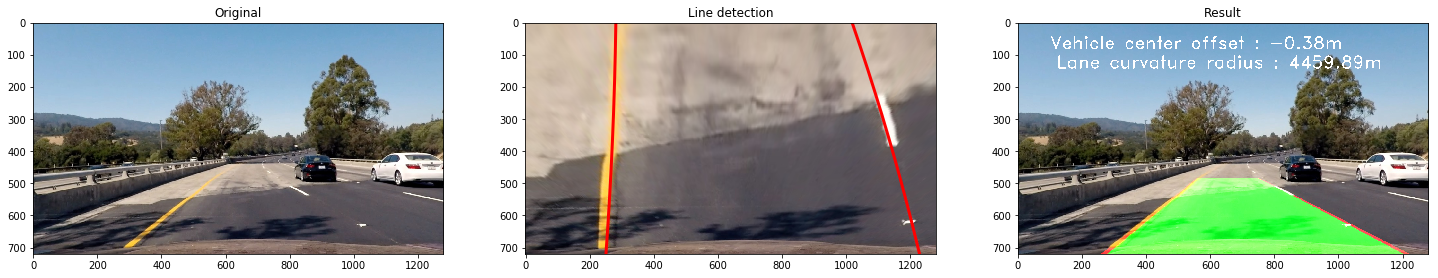

In [13]:
calibration = Calibration()
calibration.calibrate('camera_cal')
transform = Transformer()
line_fitter = LineFitter()

pipeline = Pipeline(calibration,transform,line_fitter)

for test_image in ['test_images/test2.jpg', 'test_images/test4.jpg']:
    img = mpimg.imread(test_image)
    pipeline.process_image(img, debug=True)
    plt.show()


### Example: Processing Pipeline (video)

The following cell shows the results of the image processing pipeline on a test video.


In [ ]:
import os
from moviepy.editor import VideoFileClip

output_videos_folder = 'output_videos'
if not os.path.exists(output_videos_folder):
    os.makedirs(output_videos_folder)
    
video_output = output_videos_folder +'/project_video_ouput.mp4'
clip = VideoFileClip("videos/project_video.mp4")

white_clip = clip.fl_image(pipeline.process_image) 
white_clip.write_videofile(video_output, audio=False)

In [ ]:
from IPython.display import HTML
HTML("""
<video width="320" height="240" controls>
  <source src="output_videos/project_video_ouput.mp4" type="video/mp4">
</video>
""")